In [385]:
# Libraries
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ttest_ind

In [387]:
# What are the differences in RB and EB in VK/LO sunny/cloudy conditions, and how can we explan them?

In [389]:
###### DATA PREP ######

In [391]:
# Data download
cloudy_VK_LB = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_LB_Cloudy_30min(in).csv")
sunny_VK_LB = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_LB_Sunny_30min(in).csv")
    

In [393]:
# Add a Q* column
# Q* = H + LE + G

cloudy_VK_LB['Q*_VK'] = cloudy_VK_LB['H_VK'] + cloudy_VK_LB['LE_VK']+cloudy_VK_LB['G_VK']
cloudy_VK_LB['Q*_LB'] = cloudy_VK_LB['H_LB'] + cloudy_VK_LB['LE_LB']+cloudy_VK_LB['G_LB']

sunny_VK_LB['Q*_VK'] = sunny_VK_LB['H_VK'] + sunny_VK_LB['LE_VK']+sunny_VK_LB['G_VK']
sunny_VK_LB['Q*_LB'] = sunny_VK_LB['H_LB'] + sunny_VK_LB['LE_LB']+sunny_VK_LB['G_LB']

In [459]:
# Adding the Bowen ratio B collumn

cloudy_VK_LB['B_VK'] = cloudy_VK_LB['H_VK'] / cloudy_VK_LB['LE_VK']
cloudy_VK_LB['B_LB'] = cloudy_VK_LB['H_LB'] / cloudy_VK_LB['LE_LB']

sunny_VK_LB['B_VK'] = sunny_VK_LB['H_VK'] / sunny_VK_LB['LE_VK']
sunny_VK_LB['B_LB'] = sunny_VK_LB['H_LB'] / sunny_VK_LB['LE_LB']

In [395]:
# Cleaning NaNs

cloudy_VK_LB.dropna(inplace=True)
sunny_VK_LB.dropna(inplace=True)

In [397]:
cloudy_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
0,6/26/2025 0:00,-1.293,-1.406,376.8,401.1,-24.187,-15.438900,6.973740,-10.507113,-4.306,-2.524,374.6,414.2,-41.382,-21.33170,-10.512800,3.385757,-18.972273,-28.458743
1,6/26/2025 0:30,-0.959,-1.513,394.2,403.7,-8.946,-4.871530,-0.016287,-7.253147,-4.257,-2.525,377.4,413.5,-37.832,-17.09740,-9.105850,3.417857,-12.140964,-22.785393
2,6/26/2025 1:00,-0.840,-1.417,399.3,405.8,-5.923,2.039330,-3.360050,-5.784791,-3.410,-2.583,391.3,413.3,-22.827,-12.47230,-9.210560,2.961977,-7.105511,-18.720883
3,6/26/2025 1:30,-0.625,-1.023,403.7,409.9,-5.802,-12.765700,27.048100,-5.099852,-3.563,-2.006,403.5,414.9,-12.957,-15.99430,-6.615330,2.765052,9.182548,-19.844578
4,6/26/2025 2:00,-3.211,-1.214,409.0,408.3,-1.297,-16.725000,-2.421120,-3.845273,-3.357,-2.137,399.4,414.2,-16.020,-13.15770,-0.987165,2.815506,-22.991393,-11.329359
5,6/26/2025 2:30,-1.939,-0.948,405.0,403.8,0.209,-6.887110,15.781300,-2.981902,-7.945,-1.193,389.8,409.0,-25.952,-17.77480,3.411590,2.901039,5.912288,-11.462171
6,6/26/2025 3:00,-1.552,-0.831,405.8,406.2,-1.121,-4.663050,4.871210,-3.673669,-2.930,-2.440,386.5,408.1,-22.090,-5.02085,0.315031,2.995446,-3.465509,-1.710373
7,6/26/2025 3:30,-0.377,-0.746,406.4,407.0,-0.231,-4.426530,-13.998400,-4.250012,-4.475,-1.399,401.7,409.1,-10.476,-5.90309,-4.327330,3.053245,-22.674942,-7.177175
9,6/26/2025 4:30,9.730,1.299,406.0,408.0,6.431,-11.452400,27.940200,-1.334424,13.710,1.526,404.9,407.3,9.784,26.31410,0.539516,3.232663,15.153376,30.086279
12,6/26/2025 6:00,32.530,5.357,411.1,412.0,26.273,3.690660,-67.197400,4.080569,50.010,3.959,400.6,407.8,38.851,-10.41020,-4.037470,3.910679,-59.426171,-10.536991


In [399]:
# Adding a datetime index

cloudy_VK_LB['datetime'] = pd.to_datetime(cloudy_VK_LB['Timestamp'])
cloudy_VK_LB.set_index('datetime', inplace=True)  # set datetime as index


sunny_VK_LB['datetime'] = pd.to_datetime(sunny_VK_LB['Timestamp'])
sunny_VK_LB.set_index('datetime', inplace=True)  # set datetime as index

In [401]:
###### END DATA PREP ######

In [403]:
###### RADIATION AND ENERGY BALANCE ######

In [405]:
# Most of the basic analysis was already done, e.g., timeseries

In [407]:
# Function to get an overview of the radiation and EB data
def compare_location_data(df, loc1="VK", loc2="LB", alpha=0.05):
    """
    Compare mean, std, correlation, t-test, and p-value for each variable between two locations.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns like 'Sin_VK', 'Sin_LB', etc.
        loc1 (str): Suffix for first location (default 'VK')
        loc2 (str): Suffix for second location (default 'LB')
        alpha (float): Significance threshold for p-value (default 0.05)
    
    Returns:
        pd.DataFrame: Summary table with statistics.
    """
    results = []

    # Identify base variable names
    loc1_cols = [col for col in df.columns if col.endswith(f'_{loc1}')]
    base_vars = [col.replace(f'_{loc1}', '') for col in loc1_cols
                 if f"{col.replace(f'_{loc1}', '')}_{loc2}" in df.columns]

    for var in base_vars:
        col1 = f"{var}_{loc1}"
        col2 = f"{var}_{loc2}"

        data = df[[col1, col2]].dropna()
        x = data[col1]
        y = data[col2]

        if len(data) == 0:
            continue

        # T-test
        t_stat, p_val = ttest_ind(x, y, equal_var=False)

        results.append({
            'Variable': var,
            f'{loc1} Mean': x.mean(),
            f'{loc2} Mean': y.mean(),
            f'{loc1} Std': x.std(),
            f'{loc2} Std': y.std(),
            'Correlation': np.corrcoef(x, y)[0, 1],
            'T-stat': t_stat,
            'P-value': p_val,
            'Significantly Different': 'Yes' if p_val < alpha else 'No',
            #'N': len(data)
        })

    return pd.DataFrame(results)

In [409]:
print(compare_location_data(sunny_VK_LB))
compare_location_sunny = compare_location_data(sunny_VK_LB)
compare_location_sunny.to_excel("sunny_VK_LB.xlsx", index=False)

  Variable     VK Mean     LB Mean      VK Std      LB Std  Correlation  \
0    SW_IN  320.739163  317.681429  344.802594  336.958997     0.997023   
1   SW_OUT   61.268551   30.150000   64.468047   33.347655     0.993025   
2    LW_IN  385.579592  385.210204   21.097462   18.156636     0.967315   
3   LW_OUT  448.016327  450.710204   44.625868   31.558208     0.928778   
4       RN  197.036735  222.031429  254.134969  292.991804     0.995757   
5        H    3.420930   70.314108   39.070551  116.504053     0.849566   
6       LE  145.643975   57.913883  143.775781   63.582242     0.859747   
7        G   21.654612   14.387276   43.109049    8.839665     0.387478   
8       Q*  170.719518  142.615267  215.210866  182.901906     0.953286   

     T-stat   P-value Significantly Different  
0  0.044397  0.964680                      No  
1  3.001142  0.003695                     Yes  
2  0.092896  0.926184                      No  
3 -0.345009  0.730926                      No  
4 -0.4511

In [411]:
print(compare_location_data(cloudy_VK_LB))
compare_location_cloudy = compare_location_data(cloudy_VK_LB)
compare_location_cloudy.to_excel("cloudy_VK_LB.xlsx", index=False)

  Variable     VK Mean     LB Mean      VK Std      LB Std  Correlation  \
0    SW_IN  162.015957  135.379739  229.151259  217.334654     0.674716   
1   SW_OUT   34.920674   11.860304   49.663030   21.763377     0.691142   
2    LW_IN  396.647826  395.941304   24.823141   15.574075     0.498906   
3   LW_OUT  418.041304  417.773913   16.046787    7.968561     0.774990   
4       RN  105.701804  101.686826  174.756004  190.990245     0.689927   
5        H    1.562363    9.632137   52.824168   66.302189     0.386783   
6       LE  101.264624   52.830904  123.794615   78.214845     0.566892   
7        G    1.321043    6.738235   19.290171    3.217844     0.396293   
8       Q*  104.148029   69.201276  175.221957  122.916208     0.598011   

     T-stat   P-value Significantly Different  
0  0.572014  0.568742                      No  
1  2.884476  0.005394                     Yes  
2  0.163521  0.870544                      No  
3  0.101222  0.919681                      No  
4  0.1051

PermissionError: [Errno 13] Permission denied: 'cloudy_VK_LB.xlsx'

In [413]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
datetime,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716


In [415]:
###### END RADIATION AND ENERGY BALANCE ######

In [417]:
cloudy_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
datetime,,,,,,,,,,,,,,,,,,,
2025-06-26 00:00:00,6/26/2025 0:00,-1.293,-1.406,376.8,401.1,-24.187,-15.438900,6.973740,-10.507113,-4.306,-2.524,374.6,414.2,-41.382,-21.33170,-10.512800,3.385757,-18.972273,-28.458743
2025-06-26 00:30:00,6/26/2025 0:30,-0.959,-1.513,394.2,403.7,-8.946,-4.871530,-0.016287,-7.253147,-4.257,-2.525,377.4,413.5,-37.832,-17.09740,-9.105850,3.417857,-12.140964,-22.785393
2025-06-26 01:00:00,6/26/2025 1:00,-0.840,-1.417,399.3,405.8,-5.923,2.039330,-3.360050,-5.784791,-3.410,-2.583,391.3,413.3,-22.827,-12.47230,-9.210560,2.961977,-7.105511,-18.720883
2025-06-26 01:30:00,6/26/2025 1:30,-0.625,-1.023,403.7,409.9,-5.802,-12.765700,27.048100,-5.099852,-3.563,-2.006,403.5,414.9,-12.957,-15.99430,-6.615330,2.765052,9.182548,-19.844578
2025-06-26 02:00:00,6/26/2025 2:00,-3.211,-1.214,409.0,408.3,-1.297,-16.725000,-2.421120,-3.845273,-3.357,-2.137,399.4,414.2,-16.020,-13.15770,-0.987165,2.815506,-22.991393,-11.329359
2025-06-26 02:30:00,6/26/2025 2:30,-1.939,-0.948,405.0,403.8,0.209,-6.887110,15.781300,-2.981902,-7.945,-1.193,389.8,409.0,-25.952,-17.77480,3.411590,2.901039,5.912288,-11.462171
2025-06-26 03:00:00,6/26/2025 3:00,-1.552,-0.831,405.8,406.2,-1.121,-4.663050,4.871210,-3.673669,-2.930,-2.440,386.5,408.1,-22.090,-5.02085,0.315031,2.995446,-3.465509,-1.710373
2025-06-26 03:30:00,6/26/2025 3:30,-0.377,-0.746,406.4,407.0,-0.231,-4.426530,-13.998400,-4.250012,-4.475,-1.399,401.7,409.1,-10.476,-5.90309,-4.327330,3.053245,-22.674942,-7.177175
2025-06-26 04:30:00,6/26/2025 4:30,9.730,1.299,406.0,408.0,6.431,-11.452400,27.940200,-1.334424,13.710,1.526,404.9,407.3,9.784,26.31410,0.539516,3.232663,15.153376,30.086279


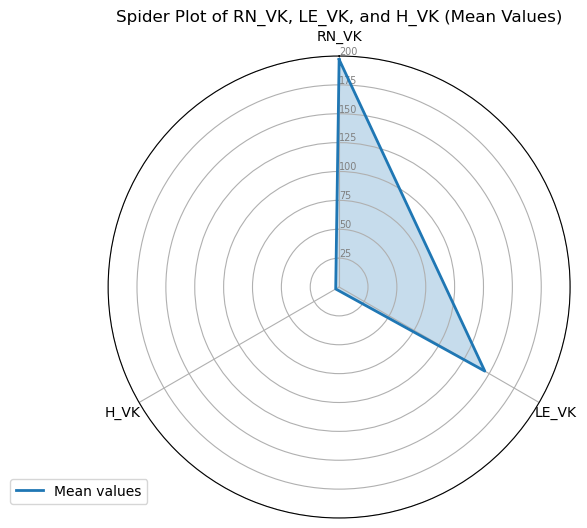

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example assuming your dataframe is named sunny_VK_LB and datetime is the index

# Select the columns you want for the radar plot
data = sunny_VK_LB[['RN_VK', 'LE_VK', 'H_VK']]

# Take the mean (or any aggregate) over the time to get one value per variable for the plot
mean_values = data.mean()

# Number of variables
categories = list(mean_values.index)
N = len(categories)

# What will be the angle of each axis in the plot? (divide the plot / number of variables)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Values to plot, and close the loop
values = mean_values.tolist()
values += values[:1]

# Create figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=7)
plt.ylim(0, 200)

# Plot data
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Mean values')
ax.fill(angles, values, alpha=0.25)

# Add a title and legend
plt.title('Spider Plot of RN_VK, LE_VK, and H_VK (Mean Values)')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [421]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
datetime,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716


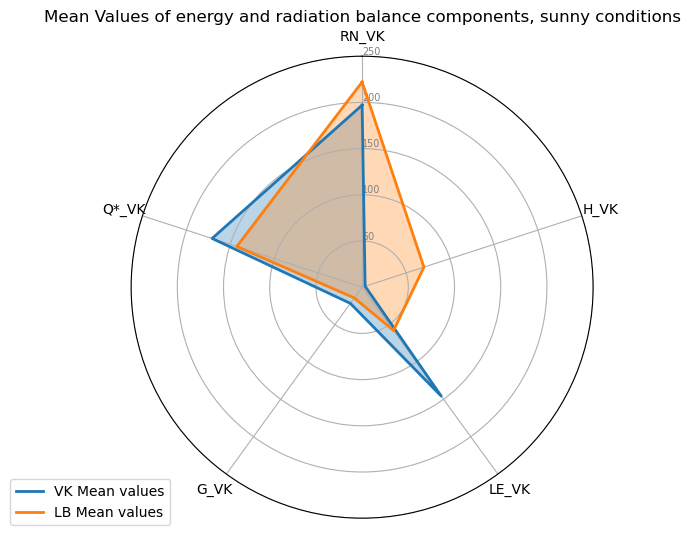

In [423]:
# Select variables for the two plots
vars_vk = ['RN_VK', 'H_VK', 'LE_VK', 'G_VK', 'Q*_VK']
vars_lb = ['RN_LB', 'H_LB', 'LE_LB', 'G_LB', 'Q*_LB']

# Calculate mean values for both sets
mean_vk = sunny_VK_LB[vars_vk].mean()
mean_lb = sunny_VK_LB[vars_lb].mean()

# Categories and number of variables
categories = vars_vk  # same variables on both plots, just RN_VK vs RN_LB differ in name
N = len(categories)

# Compute angles for each axis in the plot
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Prepare values for plotting, closing the loop
values_vk = mean_vk.tolist()
values_vk += values_vk[:1]

values_lb = mean_lb.tolist()
values_lb += values_lb[:1]

# Create figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Setup the plot style
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks(color="grey", size=7)
plt.ylim(0, 250)

# Plot first dataset
ax.plot(angles, values_vk, linewidth=2, linestyle='solid', label='VK Mean values')
ax.fill(angles, values_vk, alpha=0.3)  # more opaque

# Plot second dataset
ax.plot(angles, values_lb, linewidth=2, linestyle='solid', label='LB Mean values')
ax.fill(angles, values_lb, alpha=0.3)  # more opaque

# Title and legend
plt.title('Mean Values of energy and radiation balance components, sunny conditions')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


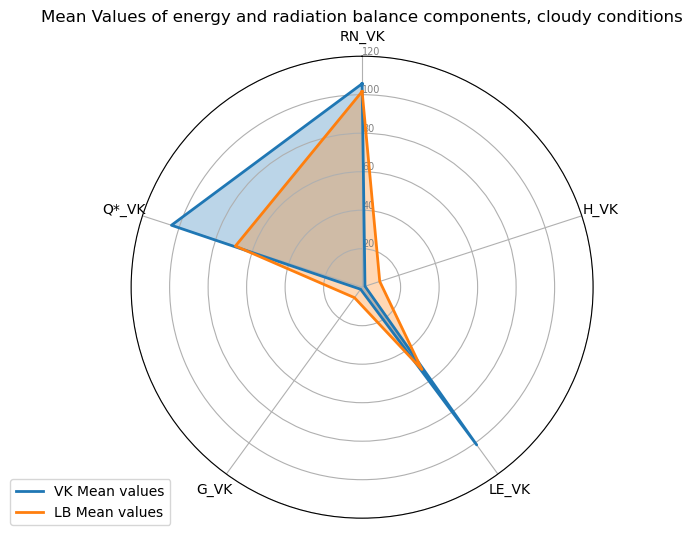

In [425]:
# Select variables for the two plots
vars_vk = ['RN_VK', 'H_VK', 'LE_VK', 'G_VK', 'Q*_VK']
vars_lb = ['RN_LB', 'H_LB', 'LE_LB', 'G_LB', 'Q*_LB']

# Calculate mean values for both sets
mean_vk = cloudy_VK_LB[vars_vk].mean()
mean_lb = cloudy_VK_LB[vars_lb].mean()

# Categories and number of variables
categories = vars_vk  # same variables on both plots, just RN_VK vs RN_LB differ in name
N = len(categories)

# Compute angles for each axis in the plot
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Prepare values for plotting, closing the loop
values_vk = mean_vk.tolist()
values_vk += values_vk[:1]

values_lb = mean_lb.tolist()
values_lb += values_lb[:1]

# Create figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Setup the plot style
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks(color="grey", size=7)
plt.ylim(0, 120)

# Plot first dataset
ax.plot(angles, values_vk, linewidth=2, linestyle='solid', label='VK Mean values')
ax.fill(angles, values_vk, alpha=0.3)  # more opaque

# Plot second dataset
ax.plot(angles, values_lb, linewidth=2, linestyle='solid', label='LB Mean values')
ax.fill(angles, values_lb, alpha=0.3)  # more opaque

# Title and legend
plt.title('Mean Values of energy and radiation balance components, cloudy conditions')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

In [427]:
cloudy_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
datetime,,,,,,,,,,,,,,,,,,,
2025-06-26 00:00:00,6/26/2025 0:00,-1.293,-1.406,376.8,401.1,-24.187,-15.438900,6.973740,-10.507113,-4.306,-2.524,374.6,414.2,-41.382,-21.33170,-10.512800,3.385757,-18.972273,-28.458743
2025-06-26 00:30:00,6/26/2025 0:30,-0.959,-1.513,394.2,403.7,-8.946,-4.871530,-0.016287,-7.253147,-4.257,-2.525,377.4,413.5,-37.832,-17.09740,-9.105850,3.417857,-12.140964,-22.785393
2025-06-26 01:00:00,6/26/2025 1:00,-0.840,-1.417,399.3,405.8,-5.923,2.039330,-3.360050,-5.784791,-3.410,-2.583,391.3,413.3,-22.827,-12.47230,-9.210560,2.961977,-7.105511,-18.720883
2025-06-26 01:30:00,6/26/2025 1:30,-0.625,-1.023,403.7,409.9,-5.802,-12.765700,27.048100,-5.099852,-3.563,-2.006,403.5,414.9,-12.957,-15.99430,-6.615330,2.765052,9.182548,-19.844578
2025-06-26 02:00:00,6/26/2025 2:00,-3.211,-1.214,409.0,408.3,-1.297,-16.725000,-2.421120,-3.845273,-3.357,-2.137,399.4,414.2,-16.020,-13.15770,-0.987165,2.815506,-22.991393,-11.329359
2025-06-26 02:30:00,6/26/2025 2:30,-1.939,-0.948,405.0,403.8,0.209,-6.887110,15.781300,-2.981902,-7.945,-1.193,389.8,409.0,-25.952,-17.77480,3.411590,2.901039,5.912288,-11.462171
2025-06-26 03:00:00,6/26/2025 3:00,-1.552,-0.831,405.8,406.2,-1.121,-4.663050,4.871210,-3.673669,-2.930,-2.440,386.5,408.1,-22.090,-5.02085,0.315031,2.995446,-3.465509,-1.710373
2025-06-26 03:30:00,6/26/2025 3:30,-0.377,-0.746,406.4,407.0,-0.231,-4.426530,-13.998400,-4.250012,-4.475,-1.399,401.7,409.1,-10.476,-5.90309,-4.327330,3.053245,-22.674942,-7.177175
2025-06-26 04:30:00,6/26/2025 4:30,9.730,1.299,406.0,408.0,6.431,-11.452400,27.940200,-1.334424,13.710,1.526,404.9,407.3,9.784,26.31410,0.539516,3.232663,15.153376,30.086279


In [429]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB
datetime,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716


In [431]:
plt.xticks??

Signature:
plt.xticks(
    ticks: 'ArrayLike | None' = None,
    labels: 'Sequence[str] | None' = None,
    *,
    minor: 'bool' = False,
    **kwargs,
) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'
Source:   
def xticks(
    ticks: ArrayLike | None = None,
    labels: Sequence[str] | None = None,
    *,
    minor: bool = False,
    **kwargs
) -> tuple[list[Tick] | np.ndarray, list[Text]]:
    """
    Get or set the current tick locations and labels of the x-axis.

    Pass no arguments to return the current values without modifying them.

    Parameters
    ----------
    ticks : array-like, optional
        The list of xtick locations.  Passing an empty list removes all xticks.
    labels : array-like, optional
        The labels to place at the given *ticks* locations.  This argument can
        only be passed if *ticks* is passed as well.
    minor : bool, default: False
        If ``False``, get/set the major ticks/labels; if ``True``, the minor
        ticks/labels.
    **kwar

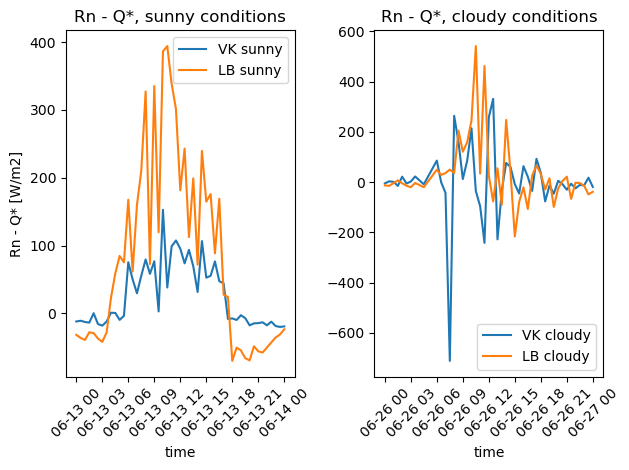

In [433]:
# Is the Rn = Q*?
fig, axs = plt.subplots(1, 2)

energy_diff_sun_VK = sunny_VK_LB['RN_VK'] - sunny_VK_LB['Q*_VK']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_VK, label="VK sunny")
energy_diff_sun_LB = sunny_VK_LB['RN_LB'] - sunny_VK_LB['Q*_LB']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_LB, label="LB sunny")
axs[0].set_title('Rn - Q*, sunny conditions')
axs[0].legend()


energy_diff_cloudy_VK = cloudy_VK_LB['RN_VK'] - cloudy_VK_LB['Q*_VK']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_VK, label="VK cloudy")
energy_diff_cloudy_LB = cloudy_VK_LB['RN_LB'] - cloudy_VK_LB['Q*_LB']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_LB, label="LB cloudy")
axs[1].set_title('Rn - Q*, cloudy conditions')
axs[1].legend()

# Rotate x-axis ticks for both plots
for ax in axs:
    plt.setp(ax.get_xticklabels(), rotation=45)

axs[0].set_ylabel('Rn - Q* [W/m2]')
axs[0].set_xlabel('time')
axs[1].set_xlabel('time')

plt.tight_layout()  # to avoid overlap
plt.show()


In [435]:
energy_diff_cloudy_VK

datetime
2025-06-26 00:00:00     -5.214727
2025-06-26 00:30:00      3.194964
2025-06-26 01:00:00      1.182511
2025-06-26 01:30:00    -14.984548
2025-06-26 02:00:00     21.694393
2025-06-26 02:30:00     -5.703288
2025-06-26 03:00:00      2.344509
2025-06-26 03:30:00     22.443942
2025-06-26 04:30:00     -8.722376
2025-06-26 06:00:00     85.699171
2025-06-26 06:30:00     -0.593122
2025-06-26 07:00:00    -43.045000
2025-06-26 07:30:00   -711.803890
2025-06-26 08:00:00    263.961633
2025-06-26 08:30:00    159.962507
2025-06-26 09:00:00     12.166373
2025-06-26 09:30:00     84.634477
2025-06-26 10:00:00    214.486303
2025-06-26 10:30:00    -35.521638
2025-06-26 11:00:00    -96.047580
2025-06-26 11:30:00   -241.984951
2025-06-26 12:00:00    257.992879
2025-06-26 12:30:00    331.425342
2025-06-26 13:00:00   -227.912633
2025-06-26 13:30:00    -33.261852
2025-06-26 14:00:00     76.199491
2025-06-26 14:30:00     60.221873
2025-06-26 15:00:00     -7.984023
2025-06-26 15:30:00    -45.486253
2025-

In [281]:
energy_diff_sun_VK.sum()

1289.543638041

In [283]:
energy_diff_sun_LB.sum()

3891.3919224610004

In [285]:
energy_diff_cloudy_VK.sum()

71.47365532199981

In [287]:
energy_diff_cloudy_LB.sum()

1591.1518436870003

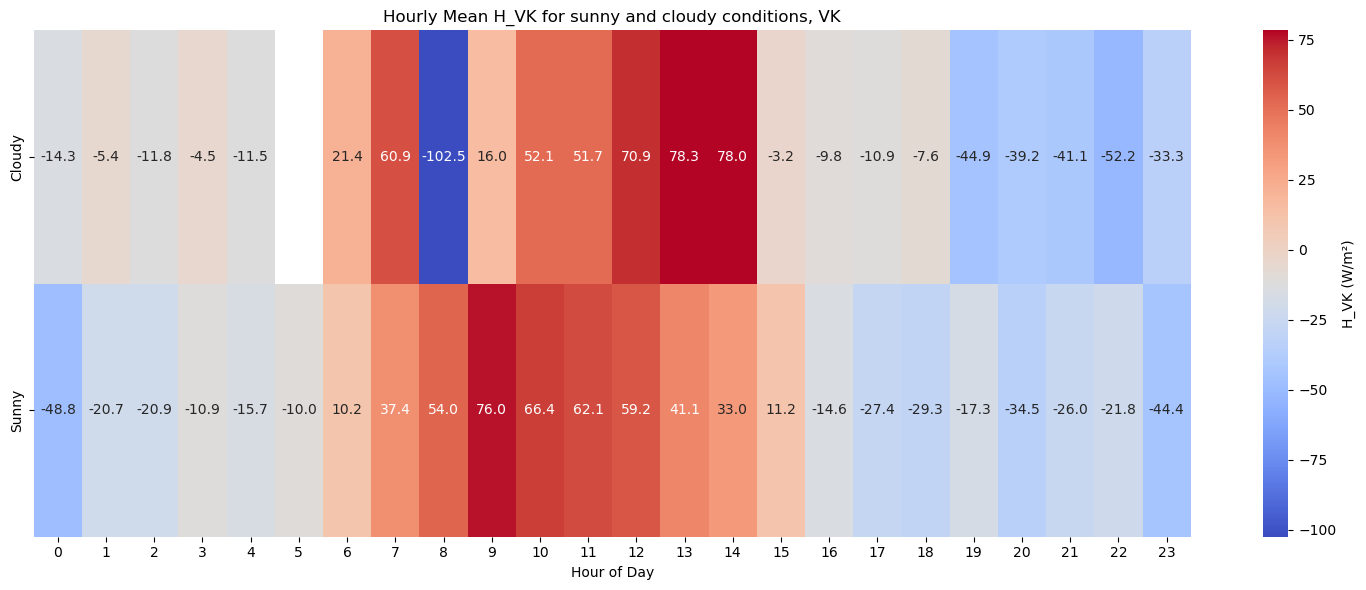

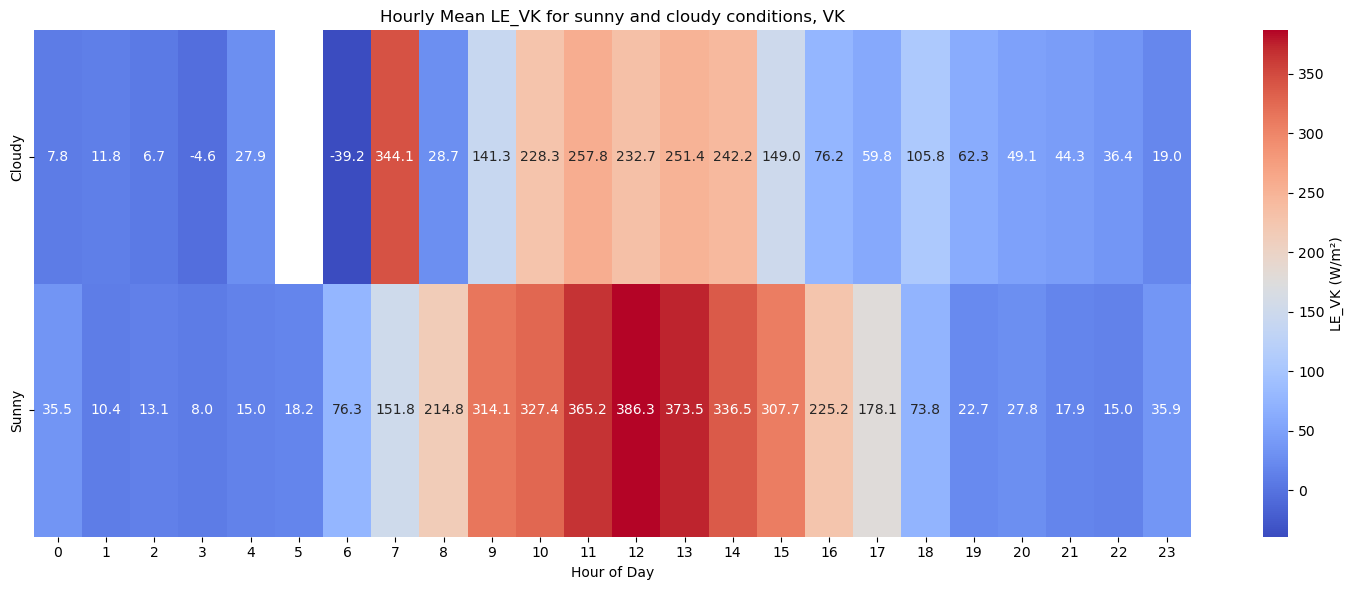

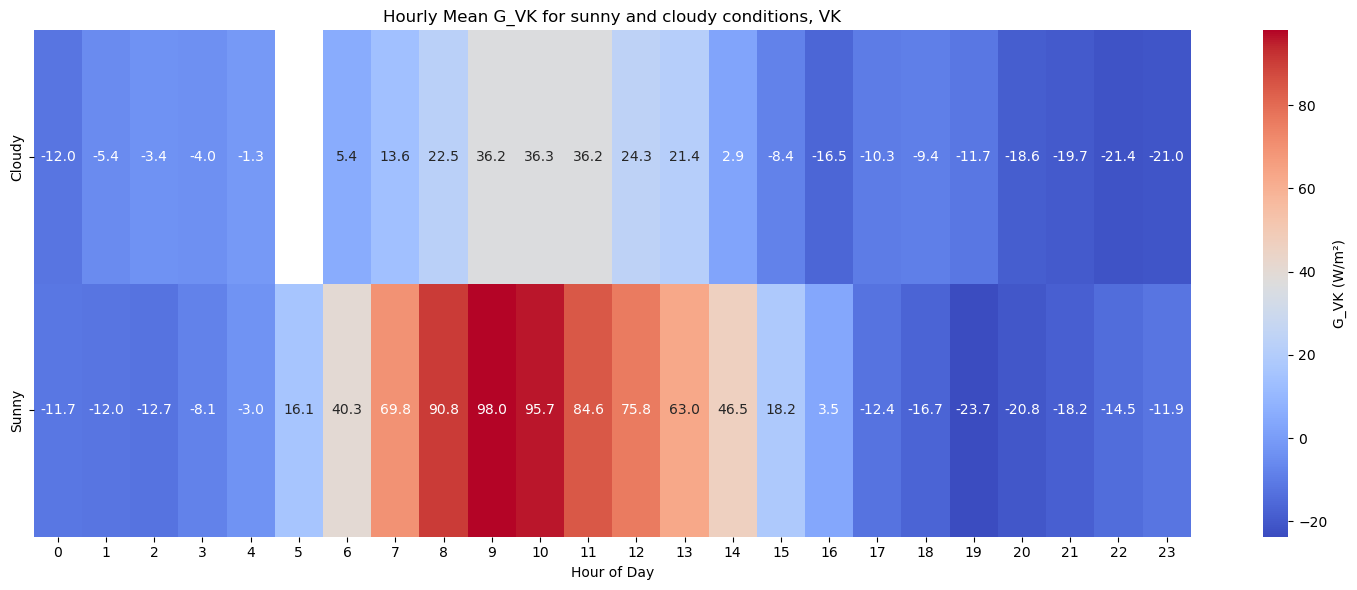

In [321]:
# What is the size of different Q* compontents in eahc hour?

# VK first
# Add 'hour' column using datetime index
sunny_VK_LB['hour'] = sunny_VK_LB.index.hour
cloudy_VK_LB['hour'] = cloudy_VK_LB.index.hour

# Variables to compare
variables = ['H_VK', 'LE_VK', 'G_VK']

# Compute hourly means
short_hourly = sunny_VK_LB.groupby('hour')[variables].mean()
tall_hourly = cloudy_VK_LB.groupby('hour')[variables].mean()

# Combine for plotting
hourly_df = pd.concat(
    {'Sunny': short_hourly, 'Cloudy': tall_hourly},
    names=['Conditions', 'Hour']
).reset_index()

# Plot heatmaps
for var in variables:
    heatmap_data = hourly_df.pivot(index='Conditions', columns='Hour', values=var)
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm', annot=True, fmt=".1f",
        cbar_kws={'label': f'{var} (W/m²)'}
    )
    plt.title(f'Hourly Mean {var} for sunny and cloudy conditions, VK')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

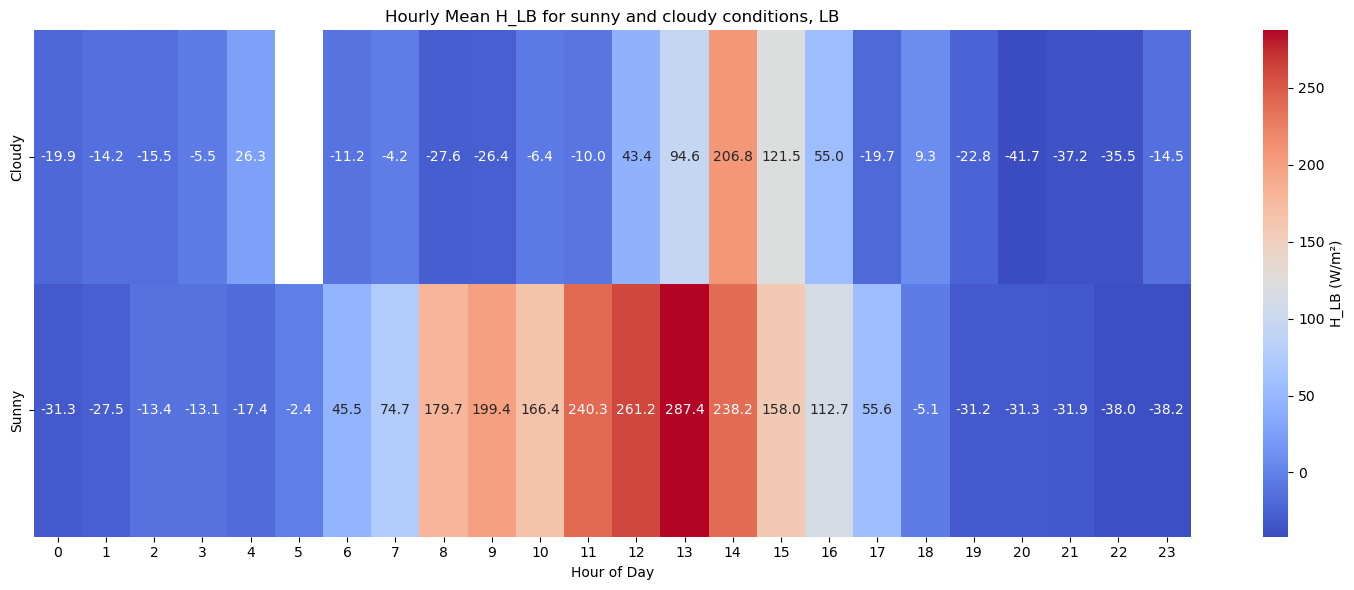

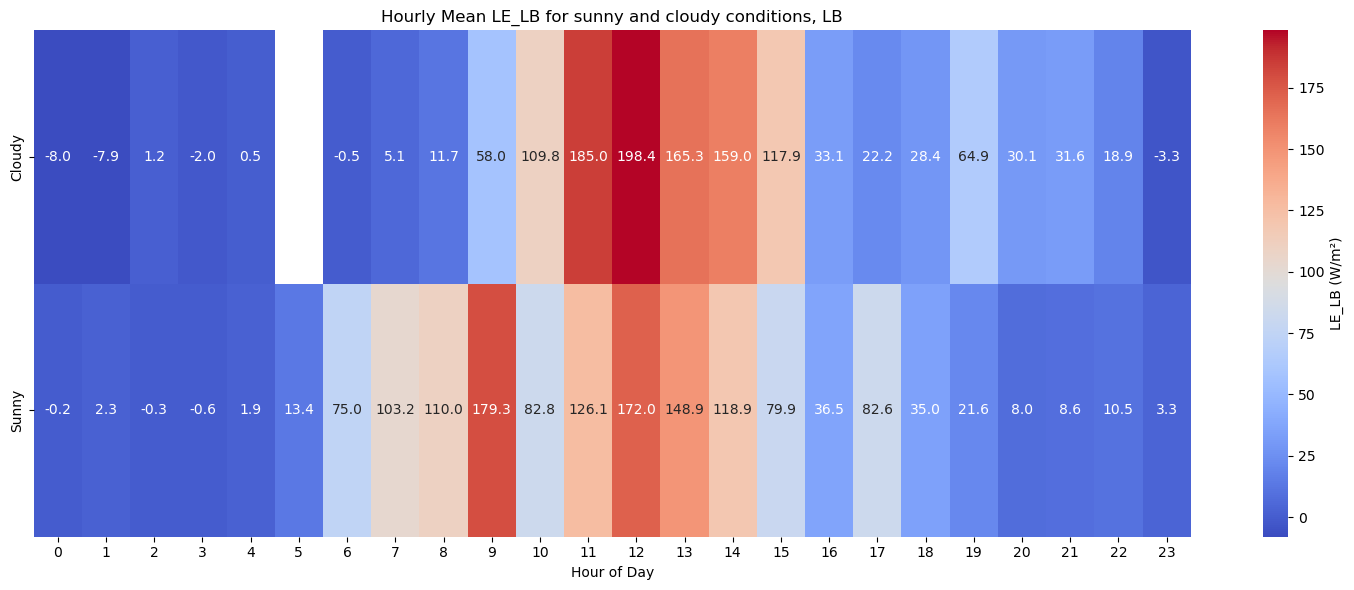

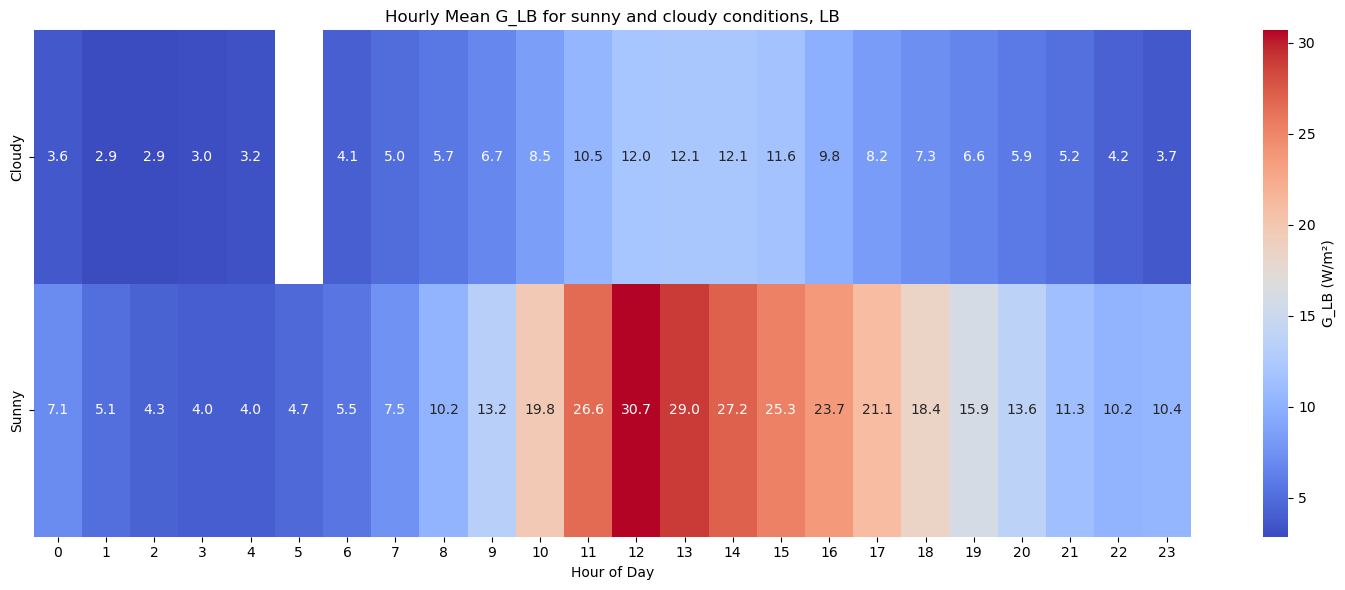

In [329]:
# Now LB
# Add 'hour' column using datetime index
sunny_VK_LB['hour'] = sunny_VK_LB.index.hour
cloudy_VK_LB['hour'] = cloudy_VK_LB.index.hour

# Variables to compare
variables = ['H_LB', 'LE_LB', 'G_LB']

# Compute hourly means
short_hourly = sunny_VK_LB.groupby('hour')[variables].mean()
tall_hourly = cloudy_VK_LB.groupby('hour')[variables].mean()

# Combine for plotting
hourly_df = pd.concat(
    {'Sunny': short_hourly, 'Cloudy': tall_hourly},
    names=['Conditions', 'Hour']
).reset_index()

# Plot heatmaps
for var in variables:
    heatmap_data = hourly_df.pivot(index='Conditions', columns='Hour', values=var)
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm', annot=True, fmt=".1f",
        cbar_kws={'label': f'{var} (W/m²)'}
    )
    plt.title(f'Hourly Mean {var} for sunny and cloudy conditions, LB')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [331]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB,hour
datetime,,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005,0
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442,0
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380,1
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576,1
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250,2
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140,2
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022,3
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278,3
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716,4


In [363]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB,hour
datetime,,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005,0
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442,0
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380,1
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576,1
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250,2
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140,2
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022,3
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278,3
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716,4


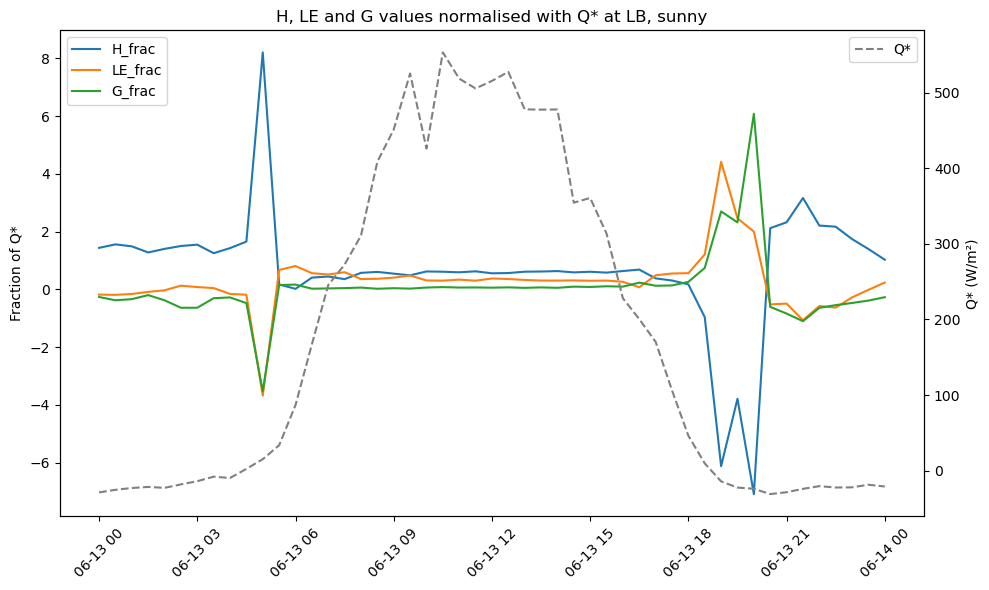

In [455]:
df = sunny_VK_LB  # choosing conditions
loc = 'LB'
conditions='sunny'

# Normalized fluxes
H_frac = df[f'H_{loc}'] / df[f'Q*_{loc}']
LE_frac = df[f'LE_{loc}'] / df[f'Q*_{loc}']
G_frac = df[f'G_{loc}'] / df[f'Q*_{loc}']

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the normalized components
ax1.plot(H_frac.index, H_frac, label="H_frac")
ax1.plot(LE_frac.index, LE_frac, label="LE_frac")
ax1.plot(G_frac.index, G_frac, label="G_frac")

ax1.set_ylabel('Fraction of Q*')
ax1.legend(loc="upper left")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title(f'H, LE and G values normalised with Q* at {loc}, {conditions}')

# Create secondary y-axis for Q*
ax2 = ax1.twinx()
ax2.plot(df.index, df['Q*_VK'], color='grey', linestyle='--', label='Q*')
ax2.set_ylabel('Q* (W/m²)')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [461]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,...,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB,B_VK,B_LB
datetime,,,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,...,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005,-1.359563,-8.024603
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,...,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442,-1.551576,-8.379060
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,...,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380,-1.882120,-9.529913
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,...,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576,-2.155775,-15.093637
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,...,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250,-1.731465,-47.488922
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,...,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140,-1.454766,11.506021
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,...,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022,-1.612147,18.803253
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,...,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278,-1.133696,26.373829
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,...,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716,-1.315685,-9.220617


In [467]:
# Does the Bowen ratio match the vegetation type, and does it change over time?

B_sunny_VK = sunny_VK_LB['B_VK'].mean()

B_sunny_LB = sunny_VK_LB['B_LB'].mean()

B_cloudy_VK = cloudy_VK_LB['B_VK'].mean()

B_cloudy_LB = cloudy_VK_LB['B_LB'].mean()


In [473]:
print(f'B_sunny_VK {B_sunny_VK}')
print(f'B_sunny_LB {B_sunny_LB }')
print(f'B_cloudy_VK {B_cloudy_VK}')
print(f'B_cloudy_LB {B_cloudy_LB}')


B_sunny_VK -0.5685414527331637
B_sunny_LB -2.8109995431241237
B_cloudy_VK 5.993822166519766
B_cloudy_LB 3.4698496620859296


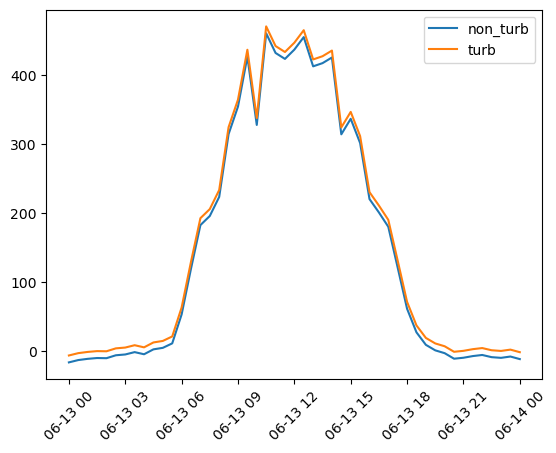

In [505]:
# Turbulent vs. not turbulent transport
# Q*-G =? H + LE
# (non-turbulent) =? (turbulent)
df = sunny_VK_LB
loc = 'VK' # VK or LB
conditions = 'sunny' # sunny or cloudy

non_turb = df[f'Q*_{loc}'] - df[f'G_{loc}']
turb = df[f'H_{loc}'] + df[f'LE_{loc}']

plt.plot(non_turb.index, non_turb, label='non_turb')
plt.plot(turb.index, turb+10, label='turb')
plt.xticks(rotation=45)
plt.legend()